
## Detecting drivers’ attention and mood using CNN
### Machine Learning Engineer Nanodegree
#### Ameen Al Baz

In [1]:
#import libraries used in the project.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os
import re
import pickle
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint  
from keras import applications, optimizers
from imutils import paths

C:\Users\ninja\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [121]:
#import the feature extractor, and set the weights to imagenet
model = applications.DenseNet121(include_top=False, weights='imagenet')

In [204]:
#specify the size the images will be resized to, and load the classifier weights of the final solution.
img_width, img_height = 224, 224
top_model_weights_path = 'toplayerweights.h5'
#set training and iamge generator parameters.
epochs = 50
batch_size = 12
gen_batch_size = 1
random.seed(42)

In [200]:
#load the imagepaths of the dataset
imagePaths = (list(paths.list_images('data_faces_jpg')))
random.seed(42)

#initialize the data and labels arrays
data = []
data_sunglasses = []
data_open = []
labels_dir = []
labels_mood = []
labels_glasses = []


# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (img_width, img_height))
    image = img_to_array(image)
    data.append(image)

    #extracting labels from the file names.
    label = imagePath.split(os.path.sep)[-1].split("_")
    
    #store feature set labels
    label.pop(0)
    l_dir = label.pop(0)
    l_mood = label.pop(0)
    l_glasses = label.pop(0).split(".")[0]

    labels_dir.append(l_dir)
    labels_mood.append(l_mood)
    labels_glasses.append(l_glasses)

#one hot encode the labels
lb_dir = LabelBinarizer()
lb_mood = LabelBinarizer()
lb_glasses = LabelBinarizer()

lb_dir.fit(labels_dir)
lb_mood.fit(labels_mood)
lb_glasses.fit(labels_glasses)

print(lb_dir.classes_)
print(lb_mood.classes_)
print(lb_glasses.classes_)

labels_dir = lb_dir.transform(labels_dir)
labels_mood = lb_mood.transform(labels_mood)
labels_glasses = lb_glasses.transform(labels_glasses)

data = np.asarray(data)
labels = [labels_dir, labels_mood, labels_glasses]

#save the binarizers
f = open("extracted_dir_binarizer", 'wb')
pickle.dump(lb_dir, f)
f.close()

f = open("extracted_mood_binarizer", 'wb')
pickle.dump(lb_mood, f)
f.close()

f = open("extracted_glasses_binarizer", 'wb')
pickle.dump(lb_mood, f)
f.close()

['left' 'right' 'straight' 'up']
['angry' 'happy' 'neutral' 'sad']
['open' 'sunglasses']


In [231]:
#this function extracts the features from the DenseNet121 and saves them for training
def save_extracted_features():
    
    #set the parameters for augmentation
    datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=10, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, fill_mode="nearest")
    
    #set the parameters for the generator
    generator = datagen.flow(
        data, np.asarray(labels[0]),
        batch_size=gen_batch_size,
        shuffle=False,
        save_to_dir='aug/', save_prefix='aug', save_format='jpg')
    
    #save features on disk
    extracted_features = model.predict_generator(generator, len(data), verbose = 1)
    np.save('extracted_features', extracted_features)
    #save targets on disk
    extracted_targets = [ i for i in np.asarray(labels[0]) for r in range(gen_batch_size) ]
    np.save('extracted_targets', extracted_targets)

In [236]:
#this model trains on the features extracted from DenseNet121
def train_top_model():
    
    #load features and targets from disk
    extracted_features = np.load('extracted_features.npy')
    extracted_targets = np.load('extracted_targets.npy')
    
    print(extracted_features.shape)
    print(extracted_targets.shape)
    
    #split the data into training and validation sets
    train_data, validation_data, train_labels, validation_labels = train_test_split(
        extracted_features, extracted_targets, test_size=0.25, shuffle=True)

    print(train_data.shape)
    print(train_labels.shape)

    #specify the NN classifier architecture
    model2 = Sequential()
    model2.add(Flatten(input_shape=train_data.shape[1:]))
    model2.add(Dense(256, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(4, activation='softmax'))

    model2.summary()
    
    #specify the optimizer    
#     opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    opt = optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
    model2.compile(optimizer=opt,
                  loss='binary_crossentropy', metrics=['accuracy'])

    #save the best weights
    checkpointer = ModelCheckpoint(filepath=top_model_weights_path, 
                               verbose=1, save_best_only=True)
    
    #save the history of the training
    history = model2.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpointer],verbose=1)
    #save to disk
    f = open("history_toplayer", 'wb')
    pickle.dump(history.history, f)
    f.close()

In [233]:
#this function predicts the images using the CNN+NN classifier
def predict_image_class(file):
    
    #load the binarizer
    f = open("extracted_dir_binarizer", 'rb')
    binarizer = pickle.load(f)
    f.close()
    
    #load the image and display it
    x = cv2.imread(file)
    x = cv2.resize(x, (img_width, img_height))
    x = img_to_array(x)/255.0
    plt.imshow(x*-1)
    x = np.expand_dims(x, axis=0)
    
    #extract features
    array = model.predict(x)
    
    #reload the NN classifier
    model2 = Sequential()
    model2.add(Flatten(input_shape=array.shape[1:]))
    model2.add(Dense(256, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(4, activation='softmax'))
    
    #reload the weights and make a classification with binarizer
    model2.load_weights('toplayerweights.h5')
    predicted = model2.predict(array, verbose = 1)[0]
    
    print(predicted)
    print(binarizer.classes_)
    
    predicted = np.expand_dims(predicted, axis=0)
    class_predicted = binarizer.inverse_transform(predicted)
    print(class_predicted)
    plt.show()


In [217]:
#this function trains the pure CNN model
def train_model_scratch():
    
    train_data, validation_data, train_labels, validation_labels = train_test_split(
        data, np.asarray(labels[1]), test_size=0.25, shuffle=True)
    
    datagen = ImageDataGenerator(rescale=1. / 255.0, rotation_range=10, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, fill_mode="nearest")
    
    generator_train = datagen.flow(
        train_data, train_labels,
        batch_size=gen_batch_size,
        save_to_dir='aug/', save_prefix='aug', save_format='jpg',
        shuffle=False)   
    
    print(train_data.shape)
    print(train_labels.shape)

    model3 = Sequential()
# CONV => RELU => POOL
    model3.add(Conv2D(32, (3, 3), padding="same", input_shape=train_data.shape[1:]))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(MaxPooling2D(pool_size=(3, 3)))
    model3.add(Dropout(0.25))
    
# (CONV => RELU) * 2 => POOL
    model3.add(Conv2D(64, (3, 3), padding="same"))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(Conv2D(64, (3, 3), padding="same"))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(MaxPooling2D(pool_size=(2, 2)))
    model3.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
    model3.add(Conv2D(128, (3, 3), padding="same"))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(Conv2D(128, (3, 3), padding="same"))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(MaxPooling2D(pool_size=(2, 2)))
    model3.add(Dropout(0.25))
    
# first (and only) set of FC => RELU layers
    model3.add(Flatten())
    model3.add(Dense(1024))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(Dropout(0.5))

    model3.add(Dense(4, activation='softmax'))
    
    opt = optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
#     opt = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model3.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath='scratch_model_weights_path.h5', 
                               verbose=1, save_best_only=True)

    history = model3.fit(train_data/255.0, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data/255.0, validation_labels),
              callbacks=[checkpointer],verbose=1)
    
    f = open("history_scratch", 'wb')
    pickle.dump(history.history, f)
    f.close()

In [205]:
#this function predicts a class using the pure CNN classifier
def predict_image_scratch(file):
    
    f = open("extracted_mood_binarizer", 'rb')
    binarizer = pickle.load(f)
    f.close()
    
    x = cv2.imread(file)
    x = cv2.resize(x, (img_width, img_height))
    x = img_to_array(x)/255.0
    plt.imshow(x*-1)
    x = np.expand_dims(x, axis=0)
        
    model3 = Sequential()
# CONV => RELU => POOL
    model3.add(Conv2D(32, (3, 3), padding="same", input_shape=x.shape[1:]))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(MaxPooling2D(pool_size=(3, 3)))
    model3.add(Dropout(0.25))
    
# (CONV => RELU) * 2 => POOL
    model3.add(Conv2D(64, (3, 3), padding="same"))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(Conv2D(64, (3, 3), padding="same"))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(MaxPooling2D(pool_size=(2, 2)))
    model3.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
    model3.add(Conv2D(128, (3, 3), padding="same"))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(Conv2D(128, (3, 3), padding="same"))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(MaxPooling2D(pool_size=(2, 2)))
    model3.add(Dropout(0.25))
    
# first (and only) set of FC => RELU layers
    model3.add(Flatten())
    model3.add(Dense(1024))
    model3.add(Activation("relu"))
    model3.add(BatchNormalization())
    model3.add(Dropout(0.5))

# use a *softmax* activation for single-label classification
# and *sigmoid* activation for multi-label classification
    model3.add(Dense(4, activation='softmax'))
    
    model3.load_weights('scratch_model_weights_path.h5')
    predicted = model3.predict(x, verbose = 1)[0]
    
    print(predicted)
    print(binarizer.classes_)
    
    predicted = np.expand_dims(predicted, axis=0)
    class_predicted = binarizer.inverse_transform(predicted)
    print(class_predicted)
    plt.show()


In [164]:
#run to extract features from DenseNet121
save_extracted_features()

111/624 [====>.........................] - ETA: 6:08

KeyboardInterrupt: 

In [237]:
#run to train the NN Classifier
train_top_model()

(624, 7, 7, 1024)
(624, 4)
(468, 7, 7, 1024)
(468, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_71 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_141 (Dense)            (None, 256)               12845312  
_________________________________________________________________
dropout_187 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 4)                 1028      
Total params: 12,846,340
Trainable params: 12,846,340
Non-trainable params: 0
_________________________________________________________________
Train on 468 samples, validate on 156 samples
Epoch 1/50
468/468 [==============================] - 9s 20ms/step - loss: 0.8424 - acc: 0.6688 - val_loss: 0.5373 - val_acc: 0.7436

Epoch 00001: val_loss improv

1/1 [==============================] - 2s 2s/step
[0.5179167  0.04249657 0.32485768 0.11472911]
['left' 'right' 'straight' 'up']
['left']


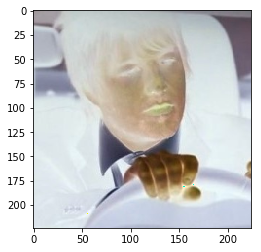

In [247]:
#run to predict the image class from the NN classifier
predict_image_class('test_faces_jpg/test9.jpg')

In [206]:
#run to train the pure CNN
train_model_scratch()

(468, 224, 224, 3)
(468, 4)
Train on 468 samples, validate on 156 samples
Epoch 1/50
468/468 [==============================] - 162s 347ms/step - loss: 1.1386 - acc: 0.6389 - val_loss: 1.2537 - val_acc: 0.6218

Epoch 00001: val_loss improved from inf to 1.25373, saving model to scratch_model_weights_path.h5
Epoch 2/50
468/468 [==============================] - 158s 337ms/step - loss: 0.7505 - acc: 0.6656 - val_loss: 0.8729 - val_acc: 0.6538

Epoch 00002: val_loss improved from 1.25373 to 0.87288, saving model to scratch_model_weights_path.h5
Epoch 3/50
468/468 [==============================] - 155s 330ms/step - loss: 0.7063 - acc: 0.6891 - val_loss: 0.9124 - val_acc: 0.6715

Epoch 00003: val_loss did not improve from 0.87288
Epoch 4/50
468/468 [==============================] - 157s 335ms/step - loss: 0.6652 - acc: 0.7057 - val_loss: 0.8898 - val_acc: 0.6490

Epoch 00004: val_loss did not improve from 0.87288
Epoch 5/50
468/468 [==============================] - 158s 338ms/step - loss

1/1 [==============================] - 2s 2s/step
[0.21603005 0.17591502 0.14261852 0.46543646]
['angry' 'happy' 'neutral' 'sad']
['sad']


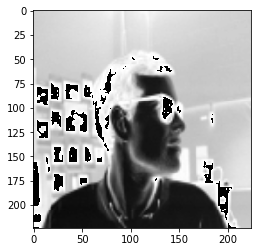

In [120]:
#run to classify using the pure CNN model
predict_image_scratch('test_faces_jpg/test6.jpg')

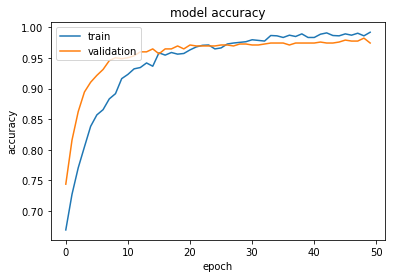

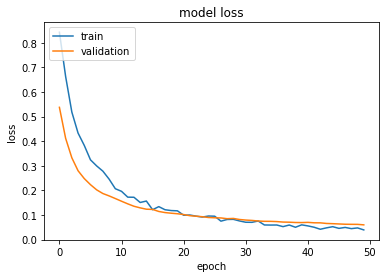

In [238]:
#run to display history of training
f = open("history_toplayer", 'rb')
# f = open("saved_weights_best/history_toplayer_mood_adam", 'rb')
history = pickle.load(f)
f.close()
#  "Accuracy"
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()